# Preprocessing


📊 [Self-Tuning Preprocessing Configuration]
→ Skewness per feature: [-0.441 -0.2  ]
→ Log transform (per feature): [False, False]
→ ADF p-values: [0.3691 0.4202] → Detrend? ✅
→ Seasonality flags (STL): [np.False_, np.True_]
→ SNR = 0.87 → Apply filter? ✅
→ Missing rate: 0.025 → Imputation: interpolate
→ EWT bands (entropy-based): 3
→ Outlier method: iqr
+---------------------+-------------+
|       Config        |    Value    |
+---------------------+-------------+
|        Shape        |  (200, 2)   |
|       Detrend       |    True     |
| Log Transform (any) |    False    |
|     Imputation      | interpolate |
|      EWT Bands      |      3      |
|       Filter?       |    True     |
|   Outlier Method    |     iqr     |
+---------------------+-------------+
✅ Self-tuning configuration complete.



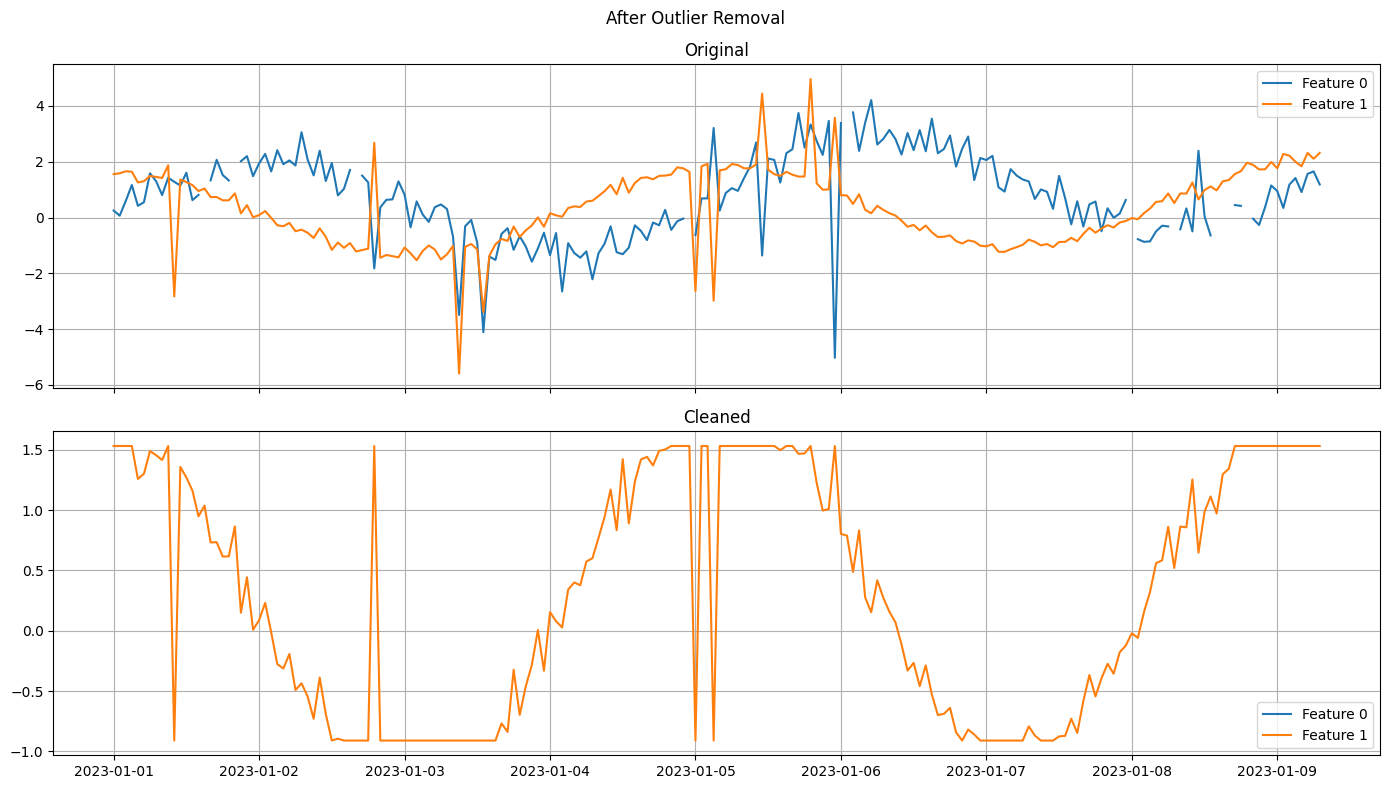

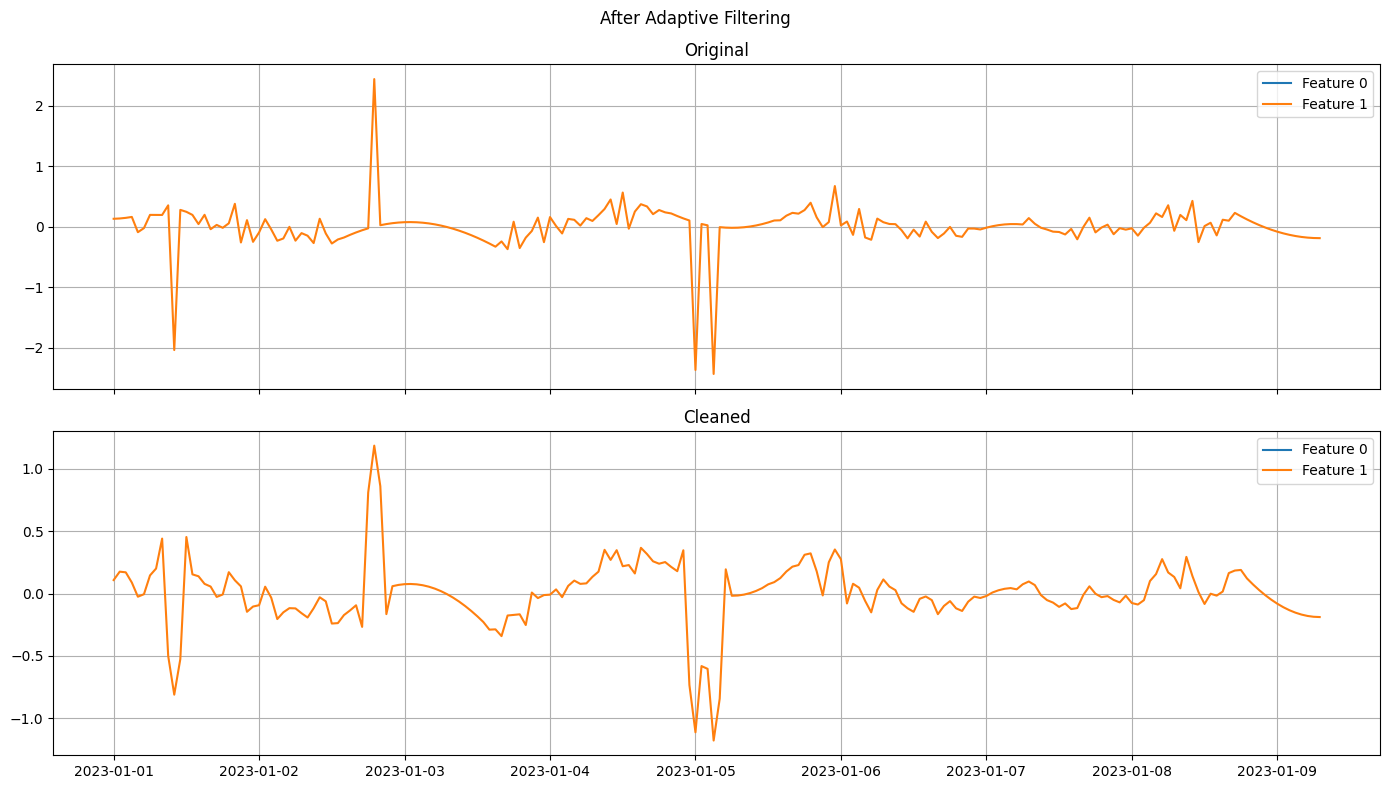

Processed data shape: (200, 2)


/home/seman/baseline/foreblocks/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:1101: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/home/seman/baseline/foreblocks/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:1106: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/home/seman/baseline/foreblocks/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:1126: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


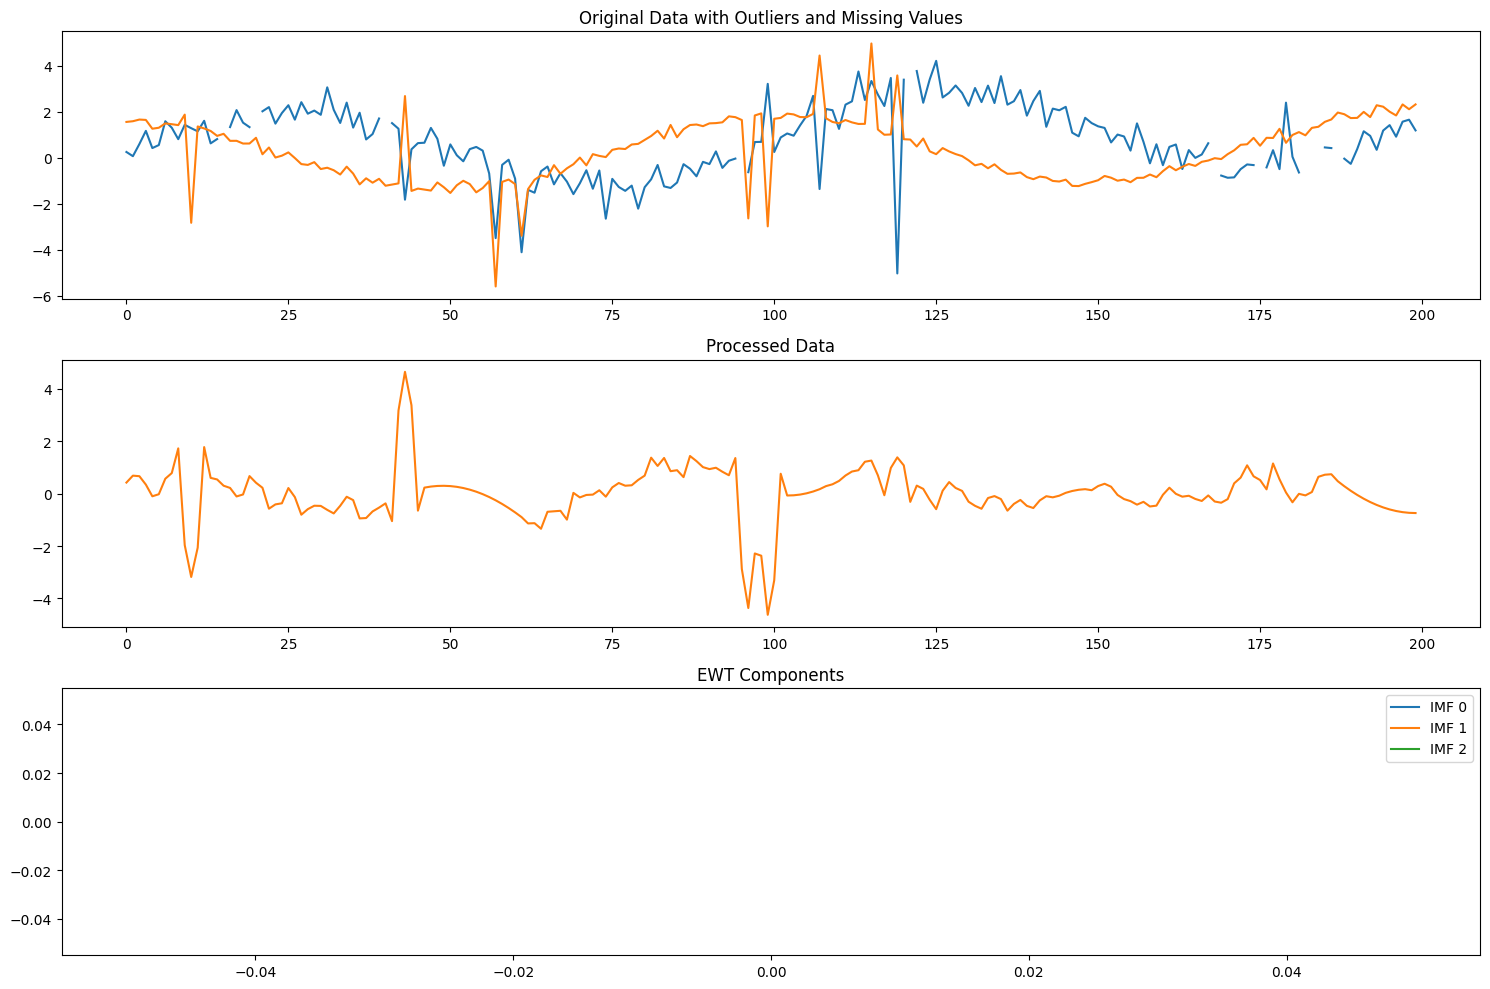

Input sequence shape: (165, 24, 2)
Target sequence shape: (165, 12, 2)


In [1]:
from foreblocks import TimeSeriesPreprocessor

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Generate synthetic time series data
np.random.seed(42)
n_samples = 200
timestamps = pd.date_range(start='2023-01-01', periods=n_samples, freq='h')

# Create a time series with trend, seasonality, and noise
t = np.linspace(0, 4*np.pi, n_samples)
trend = 0.1 * t
seasonality1 = 2 * np.sin(t)  # Daily pattern
seasonality2 = 1 * np.sin(t/24)  # Weekly pattern
noise = np.random.normal(0, 0.5, n_samples)

# Combine components
data = (trend + seasonality1 + seasonality2 + noise).reshape(-1, 1)

# Create a second feature (to demonstrate multivariate capabilities)
data2 = (0.5 * trend + 1.5 * np.cos(t) + 0.5 * np.random.normal(0, 0.3, n_samples)).reshape(-1, 1)
data = np.hstack([data, data2])  # Now we have shape [n_samples, 2]

# Add some outliers
outlier_indices = np.random.choice(n_samples, 10, replace=False)
data[outlier_indices] = data[outlier_indices] + 5 * np.random.randn(10, 2)

# Add some missing values (but not too many)
missing_indices = np.random.choice(n_samples, 10, replace=False)
data[missing_indices, 0] = np.nan  # Only make some values missing in first feature

# Create preprocessor with various techniques enabled
preprocessor = TimeSeriesPreprocessor(
    normalize=True,
    differencing=False,
    detrend=True,
    apply_ewt=True,
    window_size=24,
    horizon=12,
    remove_outliers=True,
    outlier_threshold=0.05,
    outlier_method="iqr",
    impute_method="iterative",
    ewt_bands=5,
    trend_imf_idx=0,
    log_transform=False,
    filter_window=5,
    filter_polyorder=2,
    apply_filter=True,
    self_tune=True,
)

# Fit and transform the data
X, y, processed_data = preprocessor.fit_transform(data, time_stamps=timestamps)

# Visualize the results
plt.figure(figsize=(15, 10))

plt.subplot(3, 1, 1)
plt.title('Original Data with Outliers and Missing Values')
plt.plot(data)

plt.subplot(3, 1, 2)
plt.title('Processed Data')
print("Processed data shape:", processed_data.shape)
plt.plot(processed_data)

plt.subplot(3, 1, 3)
plt.title('EWT Components')
ewt_components = preprocessor.get_ewt_components()
if ewt_components:
    for i, imf in enumerate(ewt_components[0].T):
        plt.plot(imf, label=f'IMF {i}')
    plt.legend()

plt.tight_layout()
plt.show()

print(f"Input sequence shape: {X.shape}")
print(f"Target sequence shape: {y.shape}")

# TimeSeries

In [2]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

from foreblocks import ForecastingModel
from foreblocks import LSTMDecoder, LSTMEncoder
from foreblocks import Trainer
from foreblocks.att import AttentionLayer

# Parameters
input_size = 1
hidden_size = 64
num_layers = 2
output_size = 1
target_len = 10
seq_len = 50
total_len = 300  # Total synthetic time series length

# 1. Create encoder and decoder
encoder = LSTMEncoder(input_size, hidden_size, num_layers)
decoder = LSTMDecoder(output_size, hidden_size, output_size, num_layers)

attention_module = AttentionLayer(
    method='dot',
    attention_backend='xformers',
    encoder_hidden_size=hidden_size,
    decoder_hidden_size=hidden_size,
)


model = ForecastingModel(
    encoder=encoder,
    decoder=decoder,
    target_len=target_len,
    forecasting_strategy="seq2seq",
    teacher_forcing_ratio=0.5,
    output_size=output_size,
    #attention_module=attention_module,
)

trainer = Trainer(model, optimizer=torch.optim.Adam(model.parameters(), lr=0.001), criterion=nn.MSELoss())

# 2. Generate synthetic time series
time_series = np.sin(np.linspace(0, 30 * np.pi, total_len)) + 0.1 * np.random.randn(total_len)
time_series = torch.tensor(time_series, dtype=torch.float32).unsqueeze(-1)  # Shape: [T, 1]

# 3. Prepare sliding windows for training
def create_sliding_windows(series, input_len, output_len):
    X, Y = [], []
    for i in range(len(series) - input_len - output_len):
        X.append(series[i:i+input_len])
        Y.append(series[i+input_len:i+input_len+output_len])
    return torch.stack(X), torch.stack(Y)

X, Y = create_sliding_windows(time_series, seq_len, target_len)
train_size = int(0.8 * len(X))
X_train, Y_train = X[:train_size], Y[:train_size]
X_val, Y_val = X[train_size:], Y[train_size:]

# create DataLoader
from torch.utils.data import DataLoader, TensorDataset
train_dataset = TensorDataset(X_train, Y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
data = trainer.train(train_loader)
metrics = trainer.metrics(X_val, Y_val)



Training:  52%|█████▏    | 52/100 [00:02<00:02, 22.24epoch/s]

Epoch 50: Train Loss = 0.0094


Training: 100%|██████████| 100/100 [00:04<00:00, 21.62epoch/s]

Epoch 100: Train Loss = 0.0091

Validation Forecast Error Metrics:
  MSE   = 0.010101
  RMSE  = 0.100504
  MAE   = 0.079167


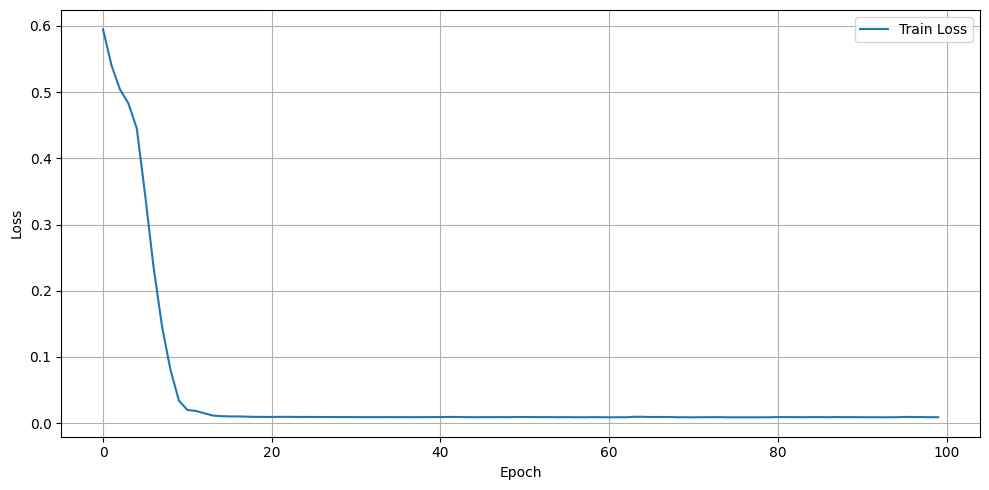

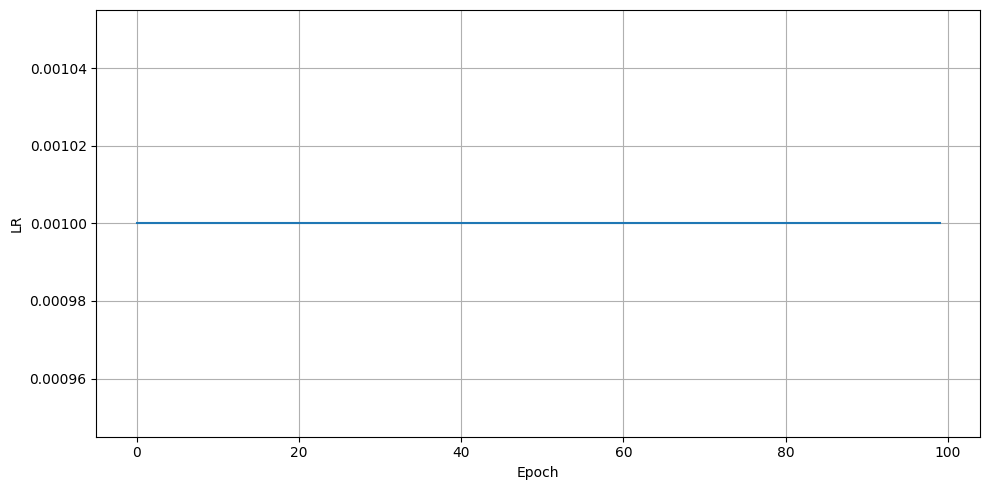

In [3]:
trainer.plot_learning_curves()

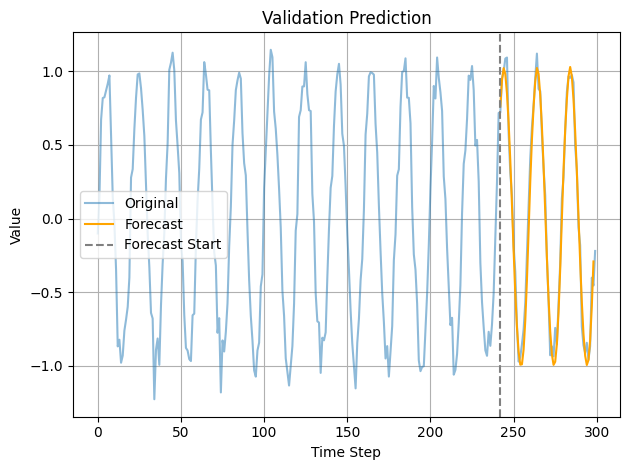

In [4]:
trainer.plot_prediction(X_val, Y_val, full_series=time_series, offset=train_size)


# Transformer

In [5]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

from foreblocks import ForecastingModel
from foreblocks import TransformerEncoder, TransformerDecoder, AttentionLayer
from foreblocks import Trainer

# Parameters
input_size = 1
hidden_size = 64
num_layers = 1
output_size = 1
target_len = 10
seq_len = 50
total_len = 1000  # Total synthetic time series length

model_params = {
    "input_processor_output_size": 1,
    "hidden_size": 64,
    "nhead": 4,
    "num_encoder_layers": 1,
    "num_decoder_layers": 1,
    "dropout": 0.1,
    "dim_feedforward": 2048,
    "seq_len": 50,
    "target_len": 10,
    "total_len": 1000,
    "input_size": 1,
    "output_size": 1,
    }

# 1. Create encoder and decoder
encoder = TransformerEncoder(
    input_size=model_params.get("input_processor_output_size", 1),
    hidden_size=model_params.get("hidden_size", 64),
    nhead=model_params.get("nhead", 4),
    num_layers=model_params.get("num_encoder_layers", 1),
    dropout=model_params.get("dropout", 0.1),
    dim_feedforward=model_params.get("dim_feedforward", 2048),
)

# Create transformer decoder
decoder = TransformerDecoder(
    input_size=model_params.get("input_processor_output_size", 1),
    hidden_size=model_params.get("hidden_size", 64),
    output_size=output_size,
    nhead=model_params.get("nhead", 2),
    num_layers=model_params.get("num_decoder_layers", 1),
    dropout=model_params.get("dropout", 0.1),
    dim_feedforward=model_params.get("dim_feedforward", 2048),
)

attention_module = AttentionLayer(
    method=model_params.get("attention_method", "dot"),
    attention_backend=model_params.get(
        "attention_backend", "xformers"
    ),
    encoder_hidden_size=hidden_size,
    decoder_hidden_size=hidden_size,
)

model = ForecastingModel(
    encoder=encoder,
    decoder=decoder,
    target_len=target_len,
    input_preprocessor=None,
    output_postprocessor=None,
    output_block=None,
    #attention_module=attention_module,
    forecasting_strategy="seq2seq",
    model_type="transformer",
    teacher_forcing_ratio=0.5,
    output_size=output_size
)

trainer = Trainer(model, optimizer=torch.optim.Adam(model.parameters(), lr=0.001), criterion=nn.MSELoss())
#trainer.set_config('num_epochs', 200)
# 2. Generate synthetic time series
time_series = np.sin(np.linspace(0, 30 * np.pi, total_len)) + 0.1 * np.random.randn(total_len)
time_series = torch.tensor(time_series, dtype=torch.float32).unsqueeze(-1)  # Shape: [T, 1]

# 3. Prepare sliding windows for training
def create_sliding_windows(series, input_len, output_len):
    X, Y = [], []
    for i in range(len(series) - input_len - output_len):
        X.append(series[i:i+input_len])
        Y.append(series[i+input_len:i+input_len+output_len])
    return torch.stack(X), torch.stack(Y)

X, Y = create_sliding_windows(time_series, seq_len, target_len)
train_size = int(0.8 * len(X))
X_train, Y_train = X[:train_size], Y[:train_size]
X_val, Y_val = X[train_size:], Y[train_size:]

# create DataLoader
from torch.utils.data import DataLoader, TensorDataset
train_dataset = TensorDataset(X_train, Y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
data = trainer.train(train_loader)




Training:   0%|          | 0/100 [00:00<?, ?epoch/s]/home/seman/baseline/foreblocks/.venv/lib/python3.13/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 10, 1])) that is different to the input size (torch.Size([32, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/seman/baseline/foreblocks/.venv/lib/python3.13/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([16, 10, 1])) that is different to the input size (torch.Size([16, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Training:  51%|█████     | 51/100 [00:04<00:05,  8.96epoch/s]

Epoch 50: Train Loss = 0.0480


Training: 100%|██████████| 100/100 [00:09<00:00, 11.07epoch/s]

Epoch 100: Train Loss = 0.0467


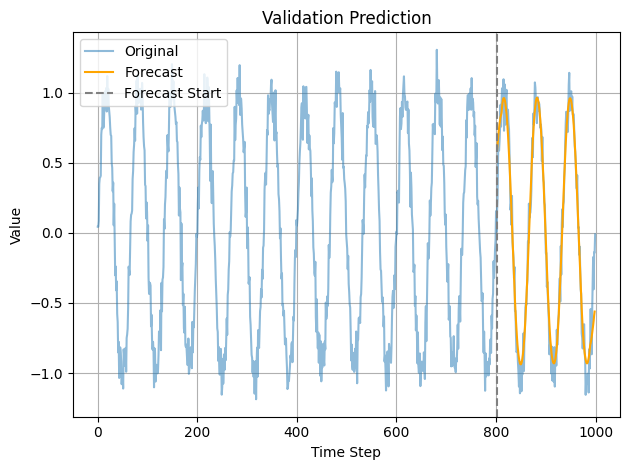

In [6]:
trainer.plot_prediction(X_val, Y_val, full_series=time_series, offset=train_size)

# Pipeline

Training:  51%|█████     | 51/100 [00:07<00:07,  6.57epoch/s]

Epoch 50: Train Loss = 0.0228


Training: 100%|██████████| 100/100 [00:15<00:00,  6.60epoch/s]

Epoch 100: Train Loss = 0.0205


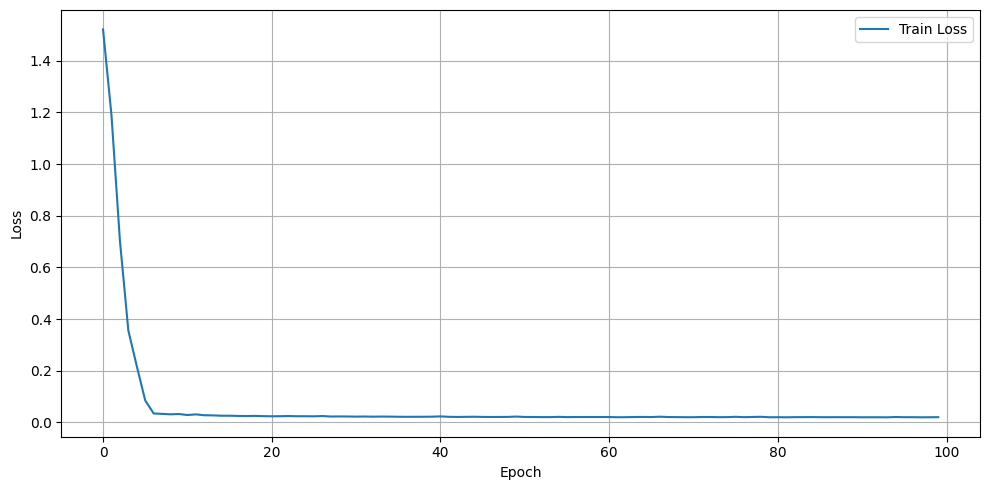

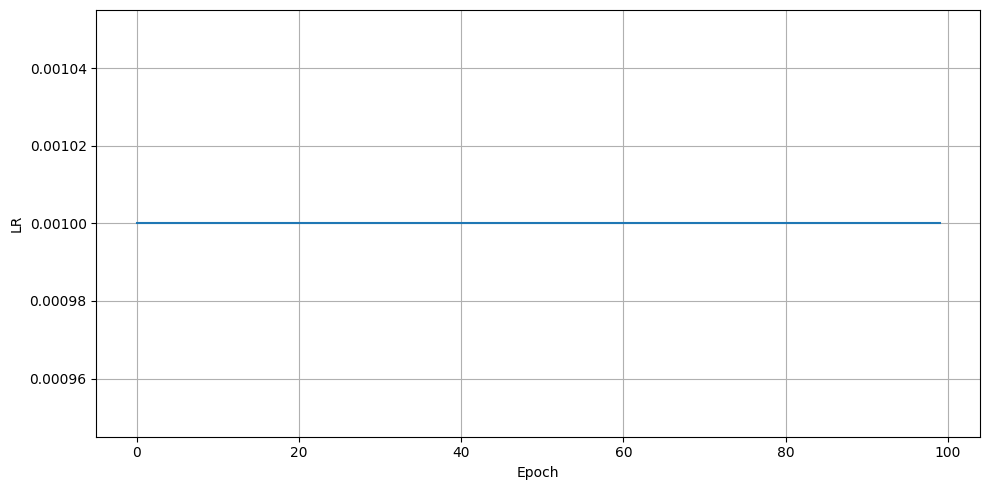

In [7]:
import numpy as np
import torch
from foreblocks import TimeSeriesSeq2Seq

input_size = 1
hidden_size = 64
num_layers = 1
output_size = 1
target_len = 10
seq_len = 50
total_len = 1000  # Total synthetic time series length

model_params = {
    "input_processor_output_size": 1,
    "hidden_size": hidden_size,
    "nhead": 4,
    "num_encoder_layers": num_layers,
    "num_decoder_layers": num_layers,
    "dropout": 0.1,
    "dim_feedforward": 2048,
    "seq_len": 50,
    "target_len": target_len,
    "total_len": total_len,
    "input_size": 1,
    "output_size": 1,
    }

pipeline = TimeSeriesSeq2Seq(model_type='lstm', model_params=model_params)


#  Generate synthetic time series
time_series = np.sin(np.linspace(0, 30 * np.pi, total_len)) + 0.1 * np.random.randn(total_len)
time_series = torch.tensor(time_series, dtype=torch.float32).unsqueeze(-1)  # Shape: [T, 1]

X, Y, raw = pipeline.preprocess(time_series, window_size=seq_len, horizon=target_len)

train_size = int(0.8 * len(X))
X_train, Y_train = X[:train_size], Y[:train_size]
X_val, Y_val = X[train_size:], Y[train_size:]
X_train = torch.tensor(X_train, dtype=torch.float32)
Y_train = torch.tensor(Y_train, dtype=torch.float32)

# Create DataLoader
from torch.utils.data import DataLoader, TensorDataset
train_dataset = TensorDataset(X_train, Y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)


history = pipeline.train_model(train_loader, num_epochs=100)